In [25]:
import numpy as np 
import torch 
from scipy import stats 
from torch import nn 
from d2l import torch as d2l

In [26]:
class HPOTrainer(d2l.Trainer):
    def validation_error(self):
        self.model.eval() 
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x) 
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1-accuracy/val_batch_idx

In [27]:
def hpo_objective_softmax_classification(config, max_epoch=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epoch)
    data = d2l.FashionMNIST(batch_size=16)
    model= d2l.SoftmaxRegression(num_outputs=10, lr = learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

In [28]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

KeyboardInterrupt: 

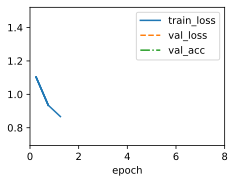

In [29]:
errors , values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f" validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)

In [ ]:
best_idx = np.argmin(errors) 
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.018968058377164504


In [30]:
import time 
from scipy import stats 
from d2l import torch as d2l

In [31]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration()->dict:
        raise NotImplementedError
    def update(self, config: dict, error: float, additional_info=None):
        pass
    
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()
        
    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else: 
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [32]:
class HPOScheduler(d2l.HyperParameters):
    def suggest(self)->dict:
        raise NotImplementedError
    
    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError
    
class BasicScheduler(HPOScheduler):
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()
        
    def suggest(self)->dict:
        return self.searcher.sample_configuration()
    
    def update(self, config: dict, error: float, info = None):
        self.searcher.update(config, error, additional_info=info)

In [33]:
class HPOTuner(d2l.HyperParameters):
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        #Bookeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []
    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: config = {config}")
            error = self.objective(**config) 
            error = float(error.cpu().detach().numpy()) 
            self.scheduler.update(config, error) 
            runtime = time.time() - start_time 
            self.bookkeeping(config, error, runtime)
            print(f" error = {error}, runtime = {runtime}")
            

In [34]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration()->dict:
        raise NotImplementedError
    def update(self, config: dict, error: float, additional_info=None):
        pass
    
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()
        
    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else: 
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [36]:
@d2l.add_to_class(HPOTuner)
def bookkeeping(self, config: dict, error: float, runtime: float):
    self.records.append({"config": config, "error": error, "runtime": runtime})
    # check if the last hyperparameter configuration performs better than incumbent
    if self.incumbent is None or self.incumbent_error > error:
        self.incumbent = config
        self.incumbent_error = error
    # add current best observed performance to the optimzaiton trajectory
    self.incumbent_trajectory.append(self.incumbent_error)
    self.current_runtime += runtime
    self.cumulative_runtime.append(self.current_runtime)

In [38]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = d2l.LeNet(lr = learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=10)
    data = d2l.FashionMNIST(batch_size = batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [39]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1), 
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128, }

 error = 0.23842716217041016, runtime = 68.45913171768188


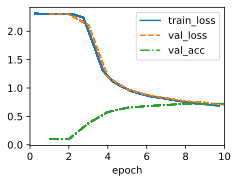

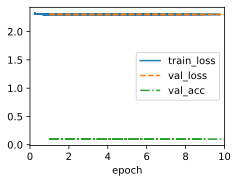

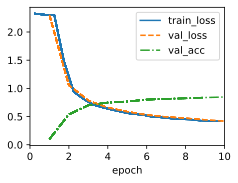

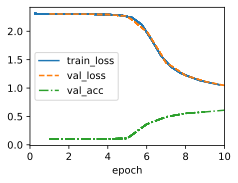

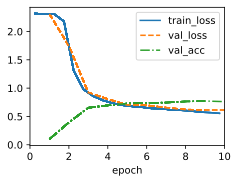

In [ ]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

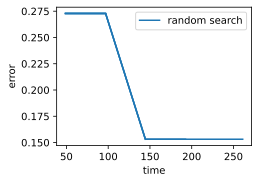

In [ ]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip( 
                             tuner.cumulative_runtime, tuner.incumbent_trajectory):
    board.draw(time_stamp, error, "random search", every_n=1)

In [46]:
import logging 
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO) 
from syne_tune import StoppingCriterion, Tuner 
from syne_tune.backend.python_backend import PythonBackend 
from syne_tune.config_space import loguniform, randint 
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

ImportError: cannot import name 'PythonBackend' from 'syne_tune.backend.python_backend' (/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/syne_tune/backend/python_backend/__init__.py)

In [47]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter 
    from d2l import torch as d2l
    
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size) 
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn) 
    report = Reporter() 
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer 
            trainer.fit(model=model, data=data) 
        else:
            trainer.fit_epoch() 
        validation_error = trainer.validation_error().cpu().detach().numpy() 
        report(epoch=epoch, validation_error=float(validation_error))

In [48]:
n_workers = 2 # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60 # 12 minutes

In [49]:
mode = "min"
metric = "validation_error"

In [50]:
config_space = { "learning_rate": loguniform(1e-2, 1), "batch_size": randint(32, 256), "max_epochs": 10, } 
initial_config = { "learning_rate": 0.1, "batch_size": 128, }

NameError: name 'loguniform' is not defined

In [51]:
trial_backend = PythonBackend( 
                    tune_function=hpo_objective_lenet_synetune, 
                    config_space=config_space, )

NameError: name 'PythonBackend' is not defined

In [ ]:
scheduler = RandomSearch( 
                         config_space, 
                         metric=metric, 
                         mode=mode, 
                         points_to_evaluate=[initial_config], )